In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import struct


In [ ]:
# ========== 1. Load Dataset ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num, rows * cols))
    return data.astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# ========== 2. Utils ==========
def shuffle_numpy(X, y):
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

def split_train_val(X, y, val_ratio=0.2):
    split_idx = int(len(X) * (1 - val_ratio))
    return X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:]

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def accuracy(Y_pred, Y_true):
    return np.mean(np.argmax(Y_pred, axis=1) == np.argmax(Y_true, axis=1))

# ========== 3. Model ==========
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim, weight_decay=0.0):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.lambda_ = weight_decay  # L2 正则化系数

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1  # (batch_size, 784) @ (784, hidden_dim) -> (batch_size, hidden_dim)
        self.a1 = self.relu(self.z1)     # (batch_size, hidden_dim)
        self.z2 = self.a1 @ self.W2 + self.b2  # (batch_size, hidden_dim) @ (hidden_dim, 10) -> (batch_size, 10)
        self.a2 = self.softmax(self.z2)  # (batch_size, 10)
        return self.a2

    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        cross_entropy = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        l2_loss = (self.lambda_ / 2) * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))  # L2 正则化项
        return cross_entropy + l2_loss

    def backward(self, X, Y_true, Y_pred, lr=0.1):
        m = Y_true.shape[0]  # batch_size
        dz2 = (Y_pred - Y_true) / m  # (batch_size, 10)
        dW2 = self.a1.T @ dz2 + self.lambda_ * self.W2  # (128, batch_size) @ (batch_size, 10) -> (128, 10)
        db2 = np.sum(dz2, axis=0, keepdims=True)        # (1, 10)
        da1 = dz2 @ self.W2.T                           # (batch_size, 10) @ (10, 128) -> (batch_size, 128)
        dz1 = da1 * (self.z1 > 0).astype(float)         # ReLU导数 (batch_size, 128)
        dW1 = X.T @ dz1 + self.lambda_ * self.W1        # (784, batch_size) @ (batch_size, 128) -> (784, 128)
        db1 = np.sum(dz1, axis=0, keepdims=True)        # (1, 128)

        # 更新参数
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

# ========== 4. Train Function (带动态绘图) ==========
def train(model, X_train, y_train, X_val, y_val, lr=0.01, epochs=100, batch_size=128,
          use_early_stopping=False, patience=5):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_loss = np.inf
    patience_count = 0

    for epoch in range(epochs):
        # 小批量訓練
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # 前向傳播與計算 loss
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)

            # 後向傳播與參數更新
            model.backward(X_batch, y_batch, y_pred, lr)

        # 每個 epoch 結束時計算整體 loss 與 accuracy
        y_pred_train = model.forward(X_train)
        train_loss = model.compute_loss(y_pred_train, y_train)
        train_acc = accuracy(y_pred_train, y_train)

        y_pred_val = model.forward(X_val)
        val_loss = model.compute_loss(y_pred_val, y_val)
        val_acc = accuracy(y_pred_val, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")

        # Debug: 印出幾次中間 loss
        if epoch % 10 == 0:
            print(f"--- Debug: 第 {epoch} 次迭代，Train Loss: {train_loss:.4f}")

        # Early Stopping 判斷
        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
            else:
                patience_count += 1
                if patience_count >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    return train_losses, val_losses, train_accs, val_accs





=== Experiment: Early Stopping ===
Epoch 00 | Train Loss: 2.1382 | Val Loss: 2.1386 | Train Acc: 0.52 | Val Acc: 0.52
--- Debug: 第 0 次迭代，Train Loss: 2.1382
Epoch 01 | Train Loss: 1.3264 | Val Loss: 1.3299 | Train Acc: 0.73 | Val Acc: 0.73
Epoch 02 | Train Loss: 0.8091 | Val Loss: 0.8100 | Train Acc: 0.81 | Val Acc: 0.81
Epoch 03 | Train Loss: 0.6175 | Val Loss: 0.6151 | Train Acc: 0.85 | Val Acc: 0.84
Epoch 04 | Train Loss: 0.5241 | Val Loss: 0.5195 | Train Acc: 0.86 | Val Acc: 0.87
Epoch 05 | Train Loss: 0.4692 | Val Loss: 0.4630 | Train Acc: 0.88 | Val Acc: 0.88
Epoch 06 | Train Loss: 0.4332 | Val Loss: 0.4260 | Train Acc: 0.88 | Val Acc: 0.89
Epoch 07 | Train Loss: 0.4079 | Val Loss: 0.4001 | Train Acc: 0.89 | Val Acc: 0.89
Epoch 08 | Train Loss: 0.3891 | Val Loss: 0.3808 | Train Acc: 0.89 | Val Acc: 0.89
Epoch 09 | Train Loss: 0.3744 | Val Loss: 0.3658 | Train Acc: 0.90 | Val Acc: 0.90
Epoch 10 | Train Loss: 0.3624 | Val Loss: 0.3537 | Train Acc: 0.90 | Val Acc: 0.90
--- Debug: 第 1

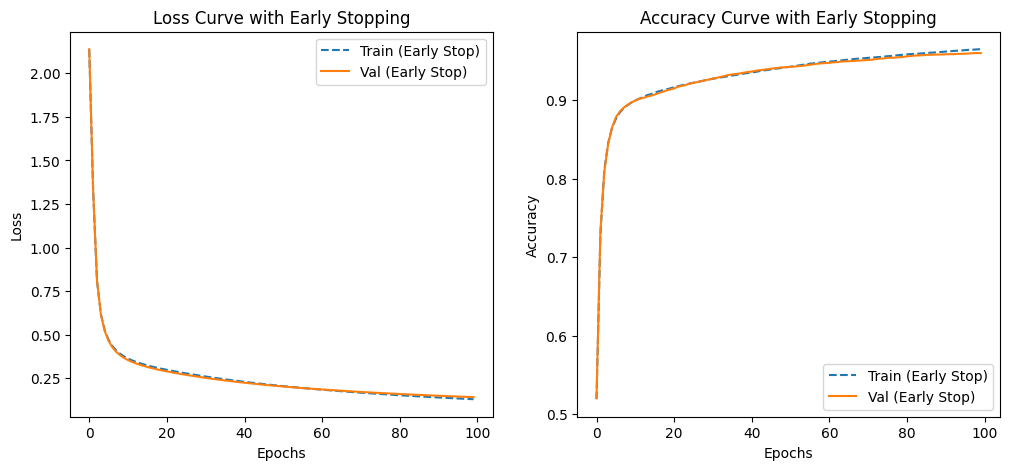

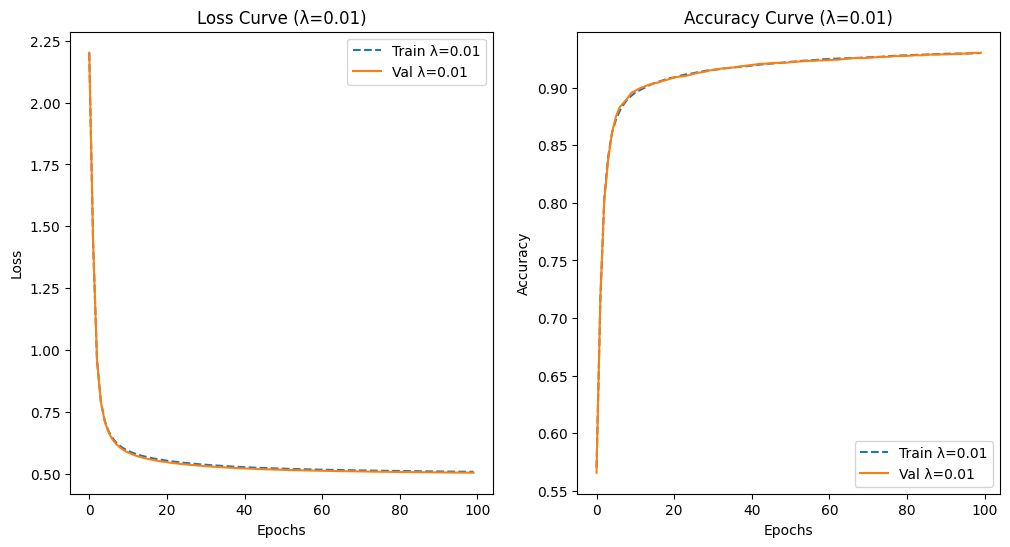

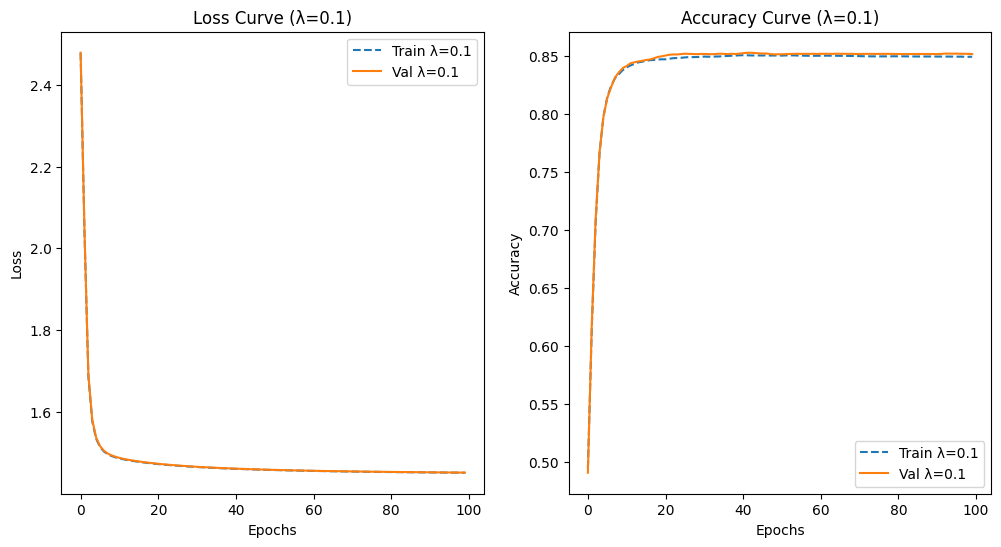

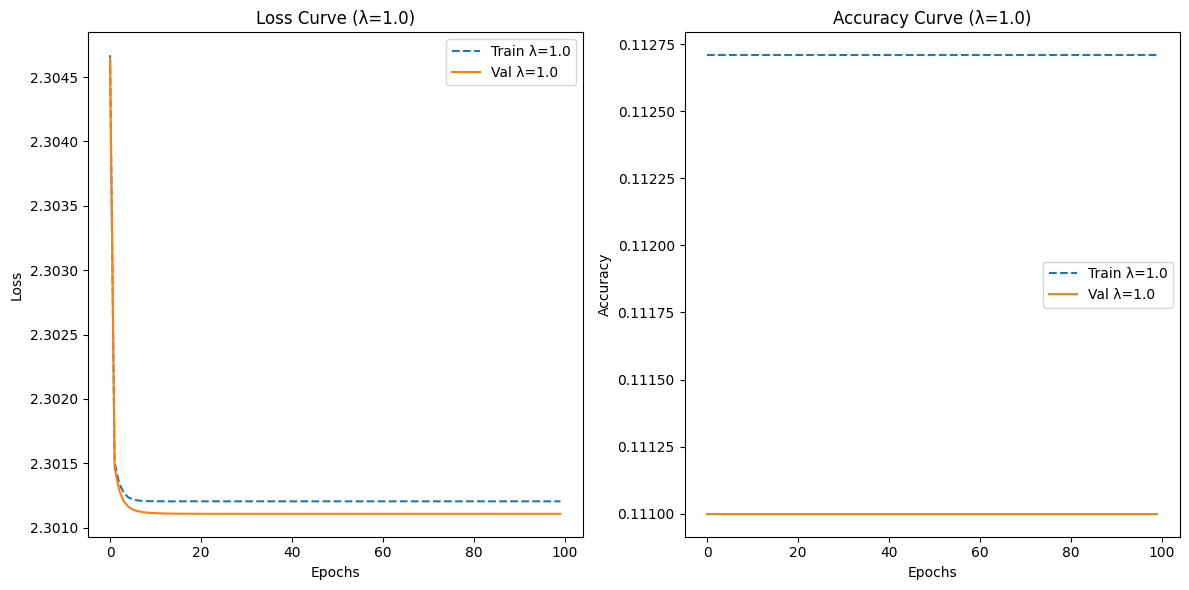

In [ ]:
# ========== 5. Main ==========
if __name__ == "__main__":
    # 加載數據
    X = load_images("train-images.idx3-ubyte___")
    y = load_labels("train-labels.idx1-ubyte___")
    X, y = shuffle_numpy(X, y)
    X_train, y_train, X_val, y_val = split_train_val(X, y)
    y_train_oh = one_hot(y_train, 10)
    y_val_oh = one_hot(y_val, 10)


    # === 實驗1：Early Stopping ===
    print("=== Experiment: Early Stopping ===")
    model_early = MLP(784, 128, 10, weight_decay=0.0)
    t1, v1, a1, a2 = train(model_early, X_train, y_train_oh, X_val, y_val_oh,
                           lr=0.01, batch_size=128, use_early_stopping=True, patience=5)

    # === 實驗2：Weight Decay (λ=0.1) ===
    print("\n=== Experiment: Weight Decay (λ=0.1) ===")
    model_l2 = MLP(784, 128, 10, weight_decay=0.1)
    t2, v2, a3, a4 = train(model_l2, X_train, y_train_oh, X_val, y_val_oh, lr=0.01, batch_size=128)

    # === 實驗3：比較不同 λ 值 ===
    print("\n=== Compare λ values ===")
    lambda_values = [0.01, 0.1, 1.0]
    results = {}
    for lambda_val in lambda_values:
        print(f"\nλ = {lambda_val}")
        model = MLP(784, 128, 10, weight_decay=lambda_val)
        results[lambda_val] = train(model, X_train, y_train_oh, X_val, y_val_oh, lr=0.01, batch_size=128)

    # 畫出不同 λ 值的驗證準確率曲線
    plt.figure(figsize=(12, 5))
    # === 畫出 Early Stopping  ===

    # Loss 曲線
    plt.subplot(1, 2, 1)
    plt.plot(t1, label="Train (Early Stop)", linestyle='--')
    plt.plot(v1, label="Val (Early Stop)")
    plt.title("Loss Curve with Early Stopping")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy 曲線
    plt.subplot(1, 2, 2)
    plt.plot(a1, label="Train (Early Stop)", linestyle='--')
    plt.plot(a2, label="Val (Early Stop)")
    plt.title("Accuracy Curve with Early Stopping")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()



    for lambda_val in lambda_values:
      train_loss, val_loss, train_acc, val_acc = results[lambda_val]

      # 創建一個新的圖表
      plt.figure(figsize=(12, 6))

      # Loss 曲線 (左邊)
      plt.subplot(1, 2, 1)
      plt.plot(train_loss, linestyle='--', label=f"Train λ={lambda_val}")
      plt.plot(val_loss, label=f"Val λ={lambda_val}")
      plt.title(f"Loss Curve (λ={lambda_val})")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()

      # Accuracy 曲線 (右邊)
      plt.subplot(1, 2, 2)
      plt.plot(train_acc, linestyle='--', label=f"Train λ={lambda_val}")
      plt.plot(val_acc, label=f"Val λ={lambda_val}")
      plt.title(f"Accuracy Curve (λ={lambda_val})")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend()

    # 顯示圖表
    plt.tight_layout()
    plt.show()


# ======================    MODEL RESULTS    =========================
# | Regularization             | Overfitting | Underfitting  |  Effect
# |----------------------------|-------------|---------------|---------
# | Early Stopping             | NO          | NO            | excellent
# | L2 Regularization (λ=0.01) | NO          | NO            | better
# | L2 Regularization (λ=0.1)  | NO          | NO            | good
# | L2 Regularization (λ=1.0)  | NO          | YES           | very bad
# =====================================================================